# SaclayStyle-2g2fv1.3

- based on the design of https://doi.org/10.1103/PhysRevX.9.011010
- 2 gate lines
- 2 flux lines
- every dimension is parametric, no magic numbers

Differences compared to v1.2:
 - Different patterning

In [1]:
import sys
sys.path.append("..")

import display as disp
import shapes as shp

from export import dxf, gds, frozen_notebook

import shapely as sp
from shapely import affinity as aff
from shapely.geometry import Point, LineString, Polygon, MultiLineString, MultiPolygon

import numpy as np
import re

<IPython.core.display.Javascript object>

### Parameters
Defining all the parameters.

In [2]:
s = 15. #cpwg s
w = 5. #cpwg w
launcher_width = 240. #launcher bondingpad size
launcher_transition = 200. #launcher triangle length
launcher_gap = 60. #gap around bonding pad of launcher
margin = 20. #empty region around edge of WF
WF = 2000. #WF size
hanger_length = 420. #length of hanger piece parallel to feedline
coupling_dist = 3. #distance of hanger from feedline
hanger_offset = 90. #offset of hanger from launcher
hanger_endgap = 23. #length of ditch at open end of resonator
meander_r = 75. #meander radius
L = 7*700+1000+420+4*2*75*np.pi #approx full length of resonator (calcualted from earlier samples)
inlauncher_width = 130 # width on inlauncher triangle base
inlauncher_length = 100 #length of inlauncher triangle
inlauncher_gap = 100 #gap around inlauncher
inlauncher_leggap = 3 #width of legs on inlauncher
samplespaceA = 300 #width of samplespace
samplespaceB = 600 #length of samplespace
pattern_close = w*4 #how close to the lines patterning should start
pattern_far = 100 #how far from line patterning should stop
pattern_space = 10 #how far apart the centers of the squares are


### Launcher and feedline
Defining the feedline on which transmission is measured, as well as the two launchers. Since shapely affine transformations return copies, rather than transforming the original, only one launcher has to be defined, all others can be copies.

Launchers are placed at the edge of the WF, to maximize the available area for the samplespace and resonator (a small margin is kept from the edge to ease the EBL process).

In [3]:
launchL, _, _ = shp.launcher( s, w,
                        launcher_width, launcher_width , launcher_transition, launcher_gap )
launchR = aff.rotate( launchL , angle=180, origin=(0,0) )
b = launchL.bounds
lw = b[2] - b[0]
lh = b[3] - b[1]
launchL = aff.translate( launchL, WF-margin-b[2] , lh/2+margin )
launchR = aff.translate( launchR, lw+margin, lh/2+margin )

feed_line = LineString(
    ((lw+margin,lh/2+margin),
     (WF-margin-lw,lh/2+margin))
)
feed_lineL, feed_lineR, _, _ = shp.line_to_cpwg( feed_line, s, w )

feedline_with_launchers = MultiPolygon( (launchL, launchR, feed_lineL, feed_lineR ) )

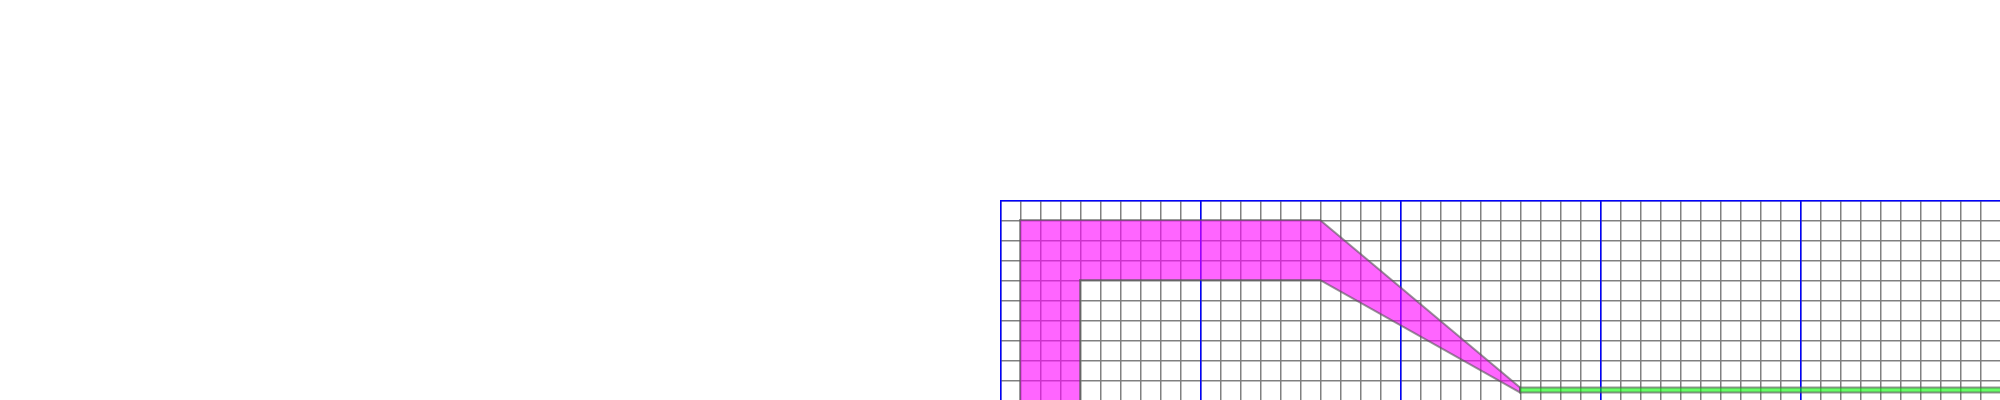

In [4]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( launchL, attribs={'fill':'#ff0'} ),
    disp.nice_svg( launchR, attribs={'fill':'#f0f'} ),
    disp.nice_svg( feed_lineL, attribs={'fill':'#0ff'} ),
    disp.nice_svg( feed_lineR, attribs={'fill':'#0f0'} ),
], (0,0,WF,WF/5)
)

### Resonator and meander
Define the hanger (the part that is coupled to the feedline), the meander that hosts most of the length of the resonator, and the connecting bits and pieces

In [5]:
# the hanger is the part capacitively coupled to the feedline
hanger_start = (lw+margin+hanger_offset, lh/2+margin+s+w*2+coupling_dist)
hanger_end = (lw+margin+hanger_offset+hanger_length, lh/2+margin+s+w*2+coupling_dist)
hanger_line = LineString( ( hanger_start, hanger_end ) )
hanger_endcap = shp.box(aff.translate(Point(hanger_end),hanger_endgap/2,0), hanger_endgap, s+2*w)

# bits and pieces connecting hanger to meander
connectors = []
connectors.append( shp.circle_segment(
    aff.translate(Point(hanger_start),0,meander_r),
    meander_r, np.pi, np.pi*1.5, 50
) )

l = launchL.bounds[3] - connectors[-1].bounds[3]
connectors.append( LineString([
    connectors[-1].coords[-1],
    aff.translate( Point(connectors[-1].coords[-1]), 0, l ),
]) )

connectors.append( shp.circle_segment(
    aff.translate( Point(connectors[-1].coords[-1]), -meander_r, 0 ),
    meander_r, np.pi/2, 0, 30
) )

connectors.append( LineString([
    connectors[-1].coords[-1],
    [margin+launcher_gap+meander_r, connectors[-1].coords[-1][1]]
]))

connectors.append( shp.circle_segment(
    aff.translate( Point(connectors[-1].coords[-1]), 0, meander_r ),
    meander_r, np.pi, np.pi*1.5, 30
))

connectors.append( LineString([
    Point(connectors[-1].coords[-1]),
    aff.translate( Point(connectors[-1].coords[-1]), 0, meander_r ),
]) )

connector_line = sp.ops.linemerge( connectors )

# meander
l = WF-margin-2*(s+w)-meander_r-connectors[-1].bounds[3] #max length of straight pieces
l_res = L - sp.ops.linemerge([hanger_line,connector_line]).length #length of resonator so far
n = int( np.ceil( l_res/(l+np.pi*meander_r) ) ) #number of straight pieces
meander_line = shp.basic_meander_line( l, meander_r, n )
meander_line = aff.affine_transform( meander_line, [0,1,1,0]+list(connectors[-1].coords[-1]) ) #flip, and move to end of connector
resonator_line = sp.ops.linemerge( [hanger_line, connector_line, meander_line] )

# shorten the last straight piece, to acheve desired length
diff = resonator_line.length - L + meander_r*np.pi/2+w+s #lengt we have to cut back
meander_line_end = aff.translate( Point(meander_line.coords[-1]), 0, -diff ) #new endpoint
meander_line = LineString( meander_line.coords[:-1]+[meander_line_end] )
resonator_line = sp.ops.linemerge( [hanger_line, connector_line, meander_line] )

# generate inlauncher connector
inlauncher_connector = shp.circle_segment(
    aff.translate( Point( meander_line.coords[-1] ), meander_r, 0 ),
    meander_r, -np.pi/2, 0, decimals=15
)
inlauncher_straight = LineString([
    inlauncher_connector.coords[-1],
    aff.translate( Point( inlauncher_connector.coords[-1] ), w+s, 0 )
])
resonator_line = sp.ops.linemerge( [resonator_line, inlauncher_connector, inlauncher_straight] )

resonatorL, resonatorR, resonator_lineL, resonator_lineR = shp.line_to_cpwg( resonator_line, s, w )

# actual inlauncher
inlauncher_template = Polygon([
    [0,-w/2],
    [0,w/2],
    [inlauncher_length,inlauncher_gap+inlauncher_width/2-s/2-w/2],
    [inlauncher_length,inlauncher_width/2-s/2-w/2]
])
inlauncherL = aff.translate( inlauncher_template ,*resonator_lineL.coords[-1] )
inlauncherR = aff.affine_transform( inlauncher_template,[1,0,0,-1]+list(resonator_lineR.coords[0]) )

resonator_with_inlauncher = MultiPolygon( [hanger_endcap, resonatorL, resonatorR, inlauncherL, inlauncherR] )

print( f"""
    Length difference: {L-resonator_line.length:.5f}um
    Total length: {resonator_line.length:.2f}um
    """)


    Length difference: 0.14947um
    Total length: 8204.81um
    


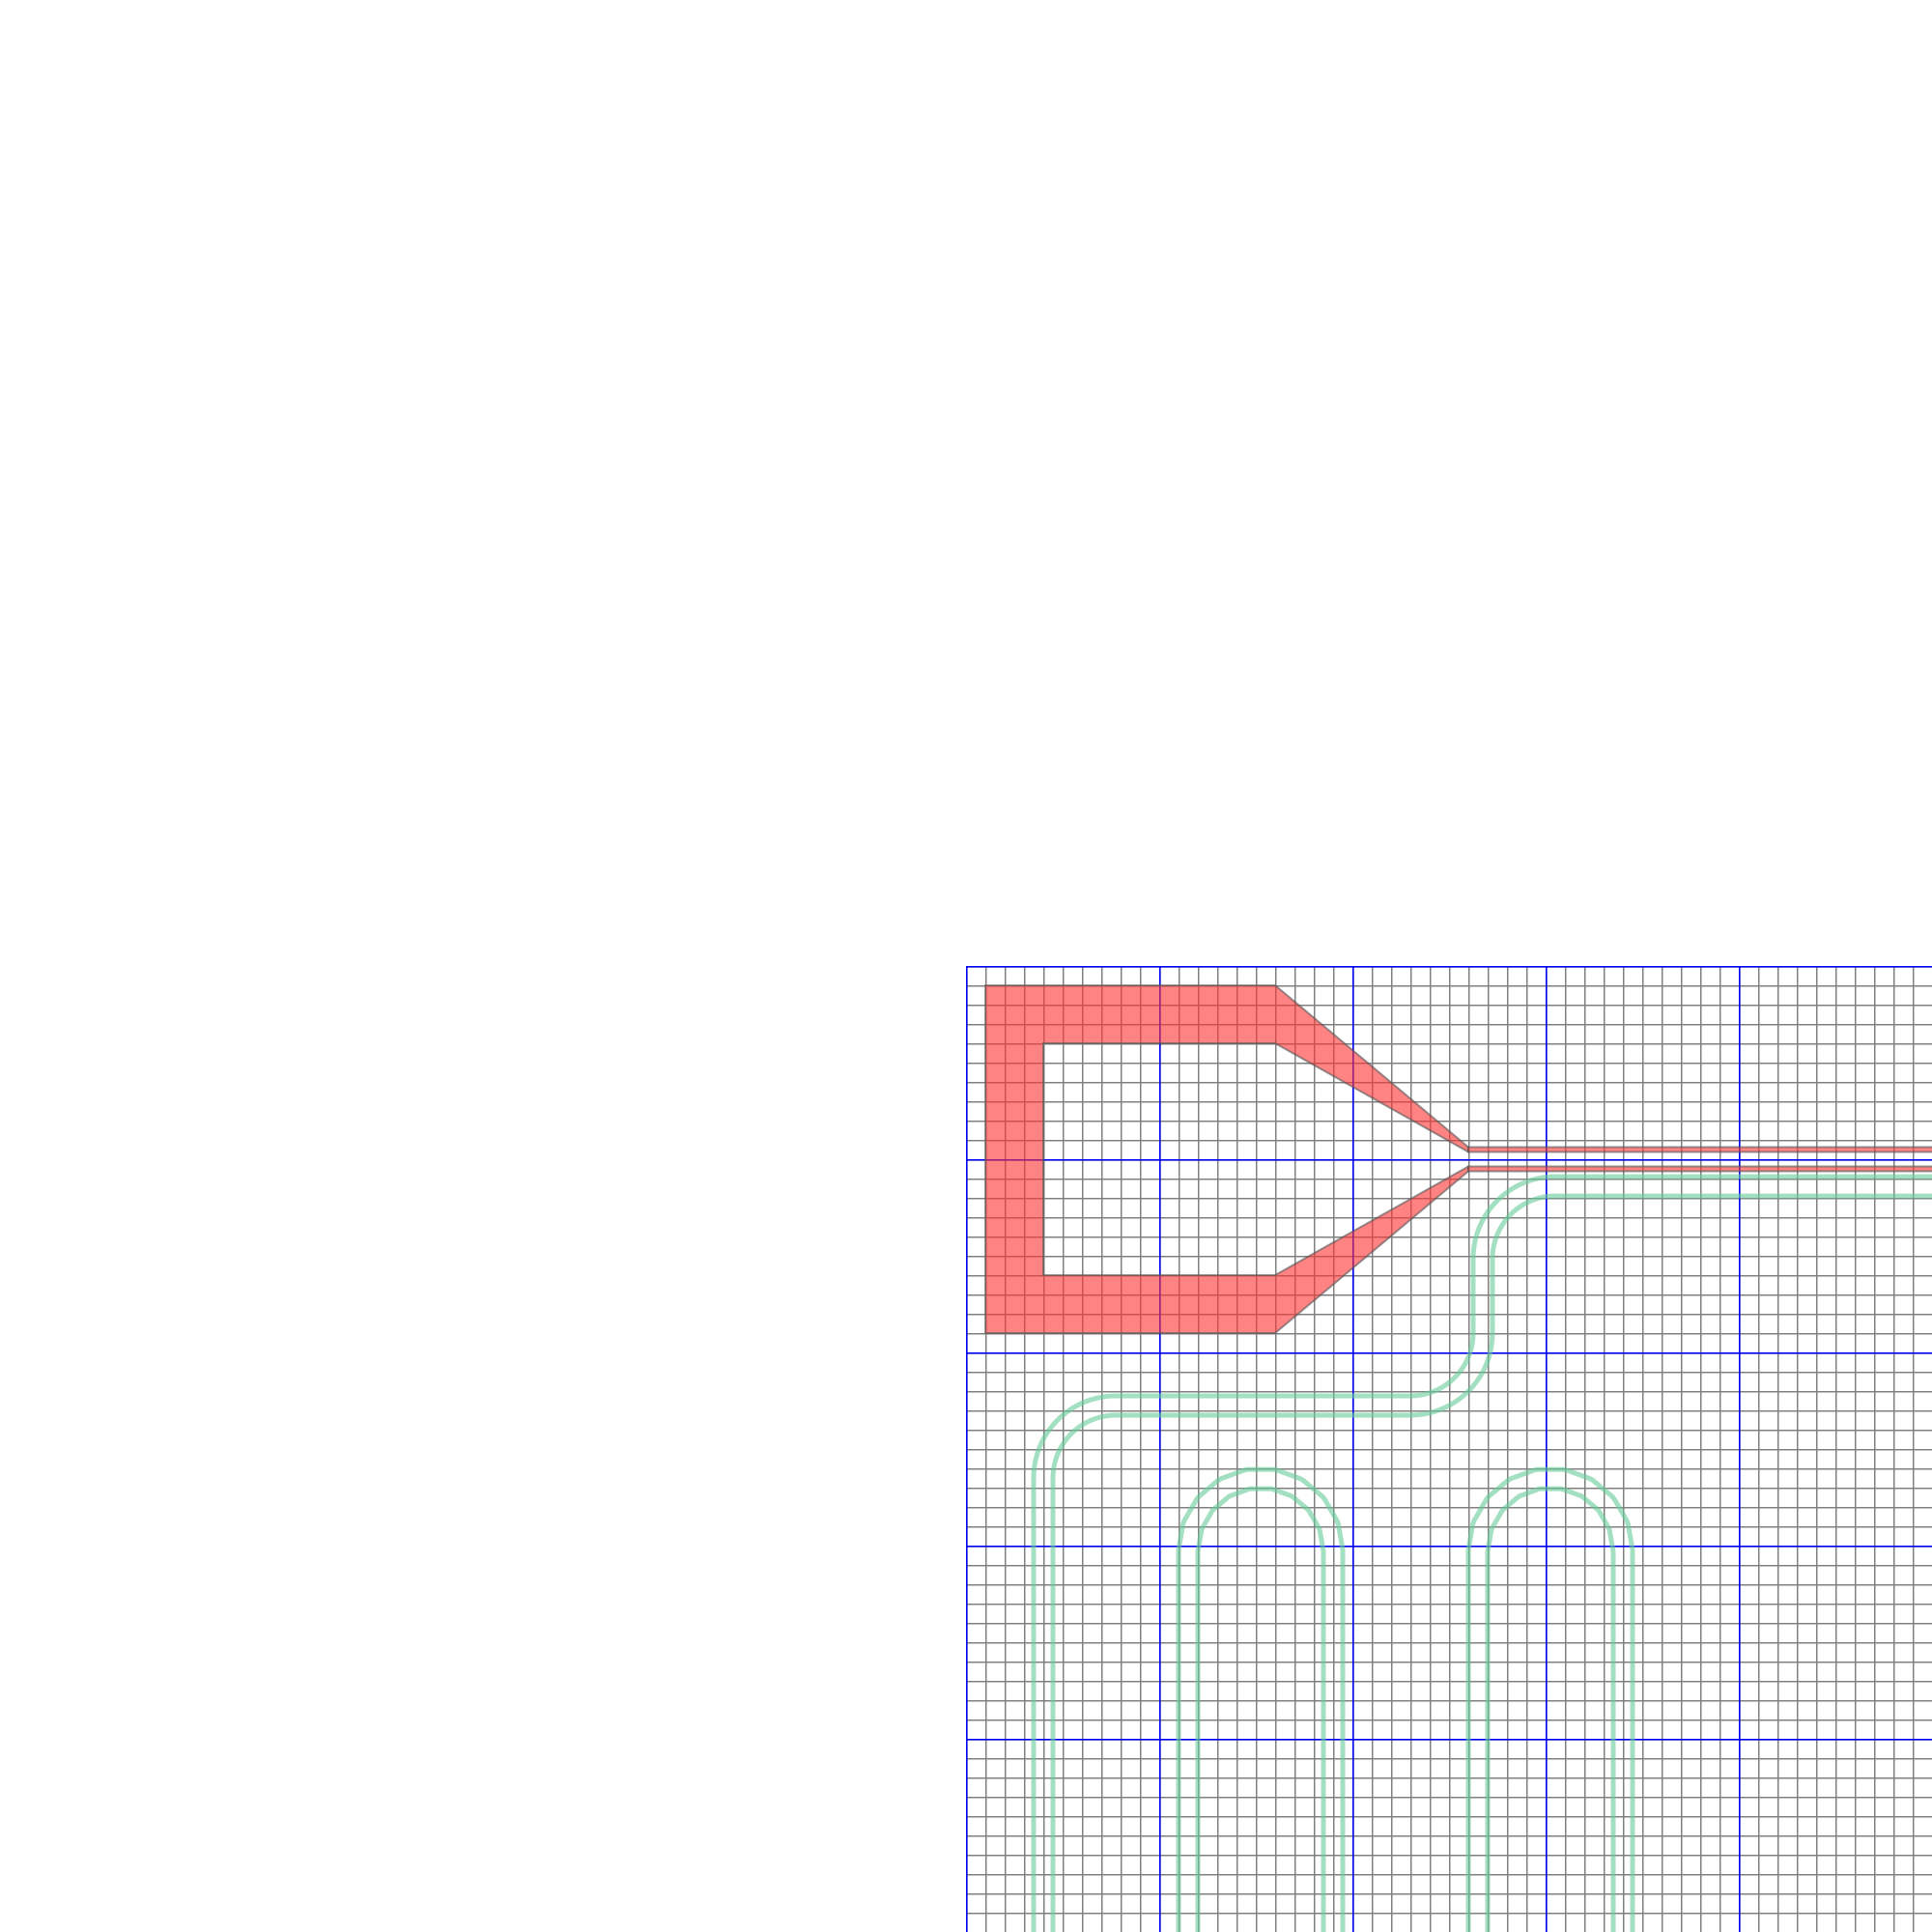

In [6]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( hanger_endcap ),
    disp.nice_svg( resonatorR ),
    disp.nice_svg( resonatorL ),
    disp.nice_svg( inlauncherR ),
    disp.nice_svg( inlauncherL, attribs={'fill':'#f0f'} ),
    
], (0,0,WF,WF)
)

### Sample space
Generating the empty space that will house the sample. It's a simple rectangle, future vers might include markers.

In [7]:
samplespace_center = aff.translate( Point(inlauncherL.bounds[2:]), inlauncher_leggap+samplespaceA/2, -samplespaceB/2 )
samplespace = shp.box( samplespace_center, samplespaceA, samplespaceB )

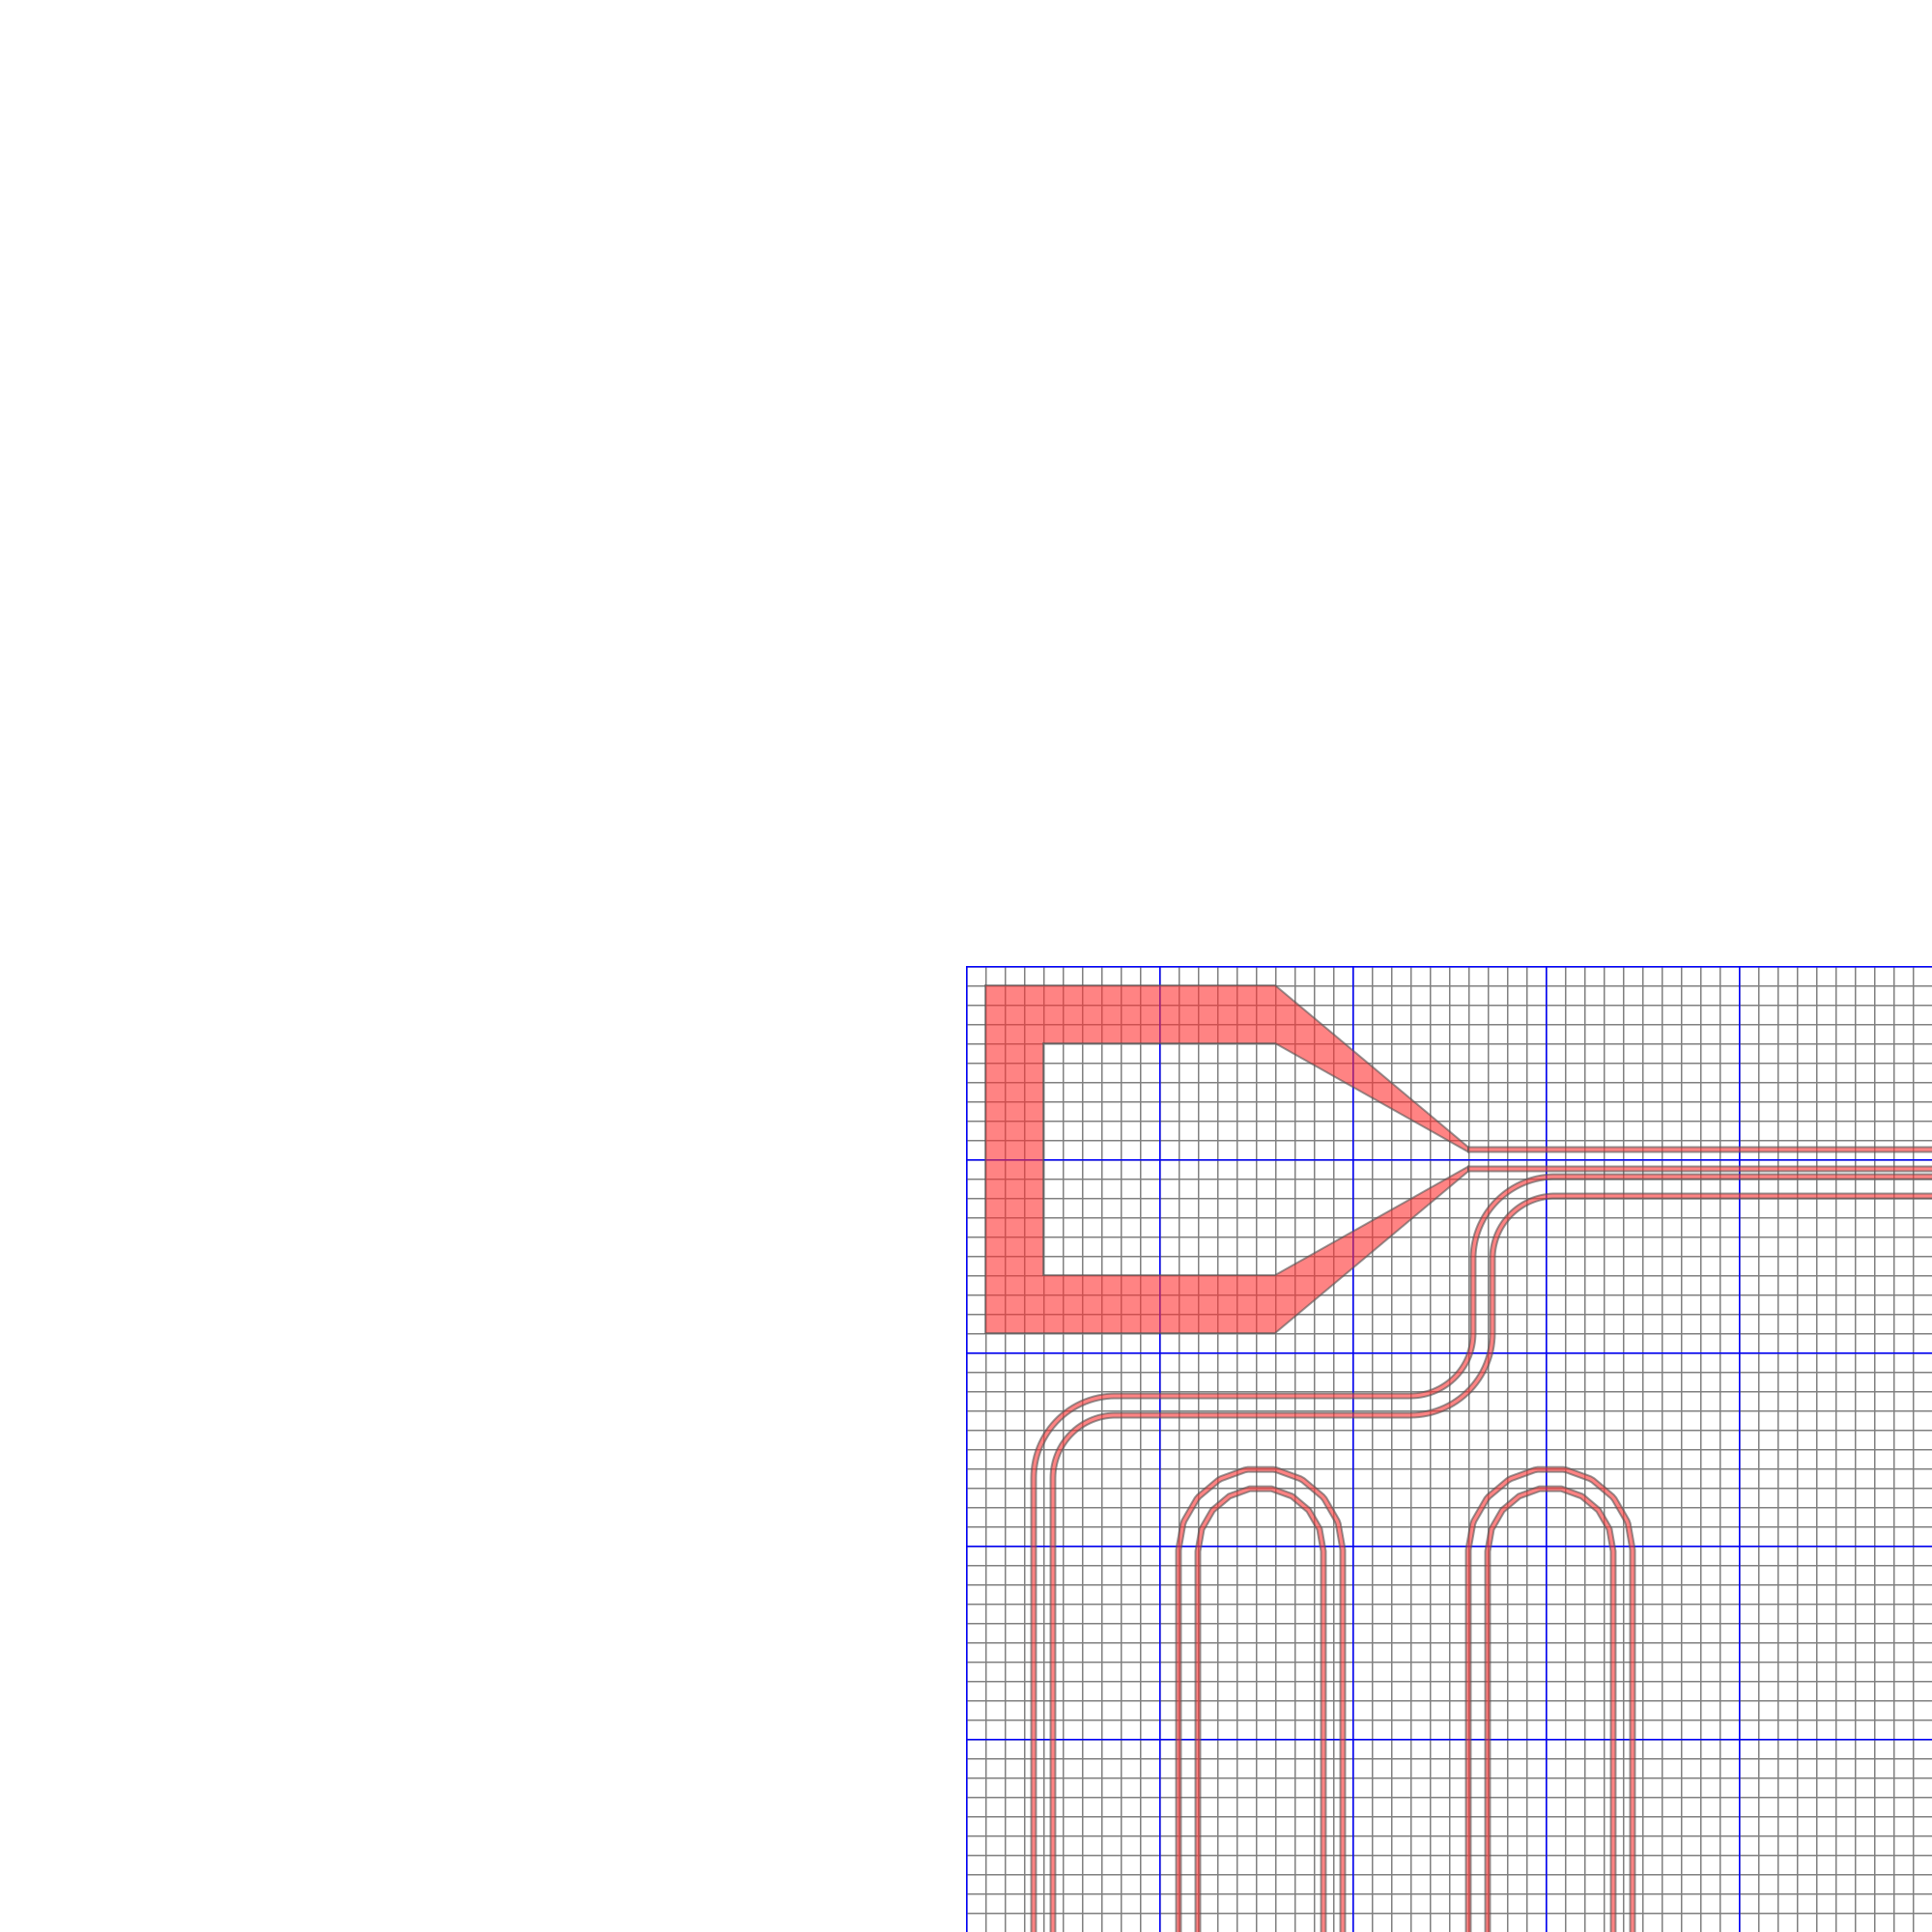

In [8]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( resonator_with_inlauncher ),
    disp.nice_svg( samplespace ),
    
], (0,0,WF,WF)
)

### Gates, and fluxlines
Generates launcher for all 4 lines along one side. Gate lines are connected to the sample space. Flux lines terminate before reaching the sample space. The current flowing through the pieces of groundplane between the fluxine and the samplespace generate the fluxes for tuning SQUIDS.

In [9]:
#launchers along the edge
gate_launchers = [ aff.translate( launchL, 0, (lh+margin*2)*i) for i in range(1,5) ]
launcher_start =[ [l.bounds[0],l.bounds[1]/2+l.bounds[3]/2] for l in gate_launchers ]

#first flux line
flux1_line = [LineString([
    launcher_start[0],
    [samplespace.bounds[0]-3*inlauncher_leggap, launcher_start[0][1]],
])]
flux1_line.append(shp.circle_segment(
    aff.translate( Point(flux1_line[-1].coords[-1]), 0, meander_r ),
    meander_r, np.pi, np.pi*1.5
))
flux1_line.append(LineString([
    flux1_line[-1].coords[-1],
    [flux1_line[-1].coords[-1][0], samplespace.bounds[1]+samplespaceB-inlauncher_gap*2-inlauncher_width-2*meander_r],
]))
flux1_line.append(shp.circle_segment(
    aff.translate( Point(flux1_line[-1].coords[-1]), meander_r, 0 ),
    meander_r, -np.pi*.5, 0, decimals=14
))
flux1_line.append(LineString([
    flux1_line[-1].coords[-1],
    aff.translate( Point(flux1_line[-1].coords[-1]), inlauncher_leggap*2, 0 )
]))
flux1_line = sp.ops.linemerge( flux1_line )
flux1R, flux1L, _, _ = shp.line_to_cpwg( flux1_line, s, w )

#second flux line
flux2_line = LineString([
    launcher_start[2],
    [samplespace.bounds[2]+inlauncher_leggap,launcher_start[2][1]]
])
flux2R, flux2L, _, _ = shp.line_to_cpwg( flux2_line, s, w )

#first gate line
gate1_line = LineString([
    launcher_start[1],
    [samplespace_center.x,launcher_start[1][1]],
    [samplespace_center.x,samplespace.bounds[1]],
])
gate1R, gate1L, _, _ = shp.line_to_cpwg( gate1_line, s, w )

#second gate line
gate2_line = LineString([
    launcher_start[3],
    [samplespace_center.x,launcher_start[3][1]],
    [samplespace_center.x,samplespace.bounds[3]],
])
gate2R, gate2L, _, _ = shp.line_to_cpwg( gate2_line, s, w )

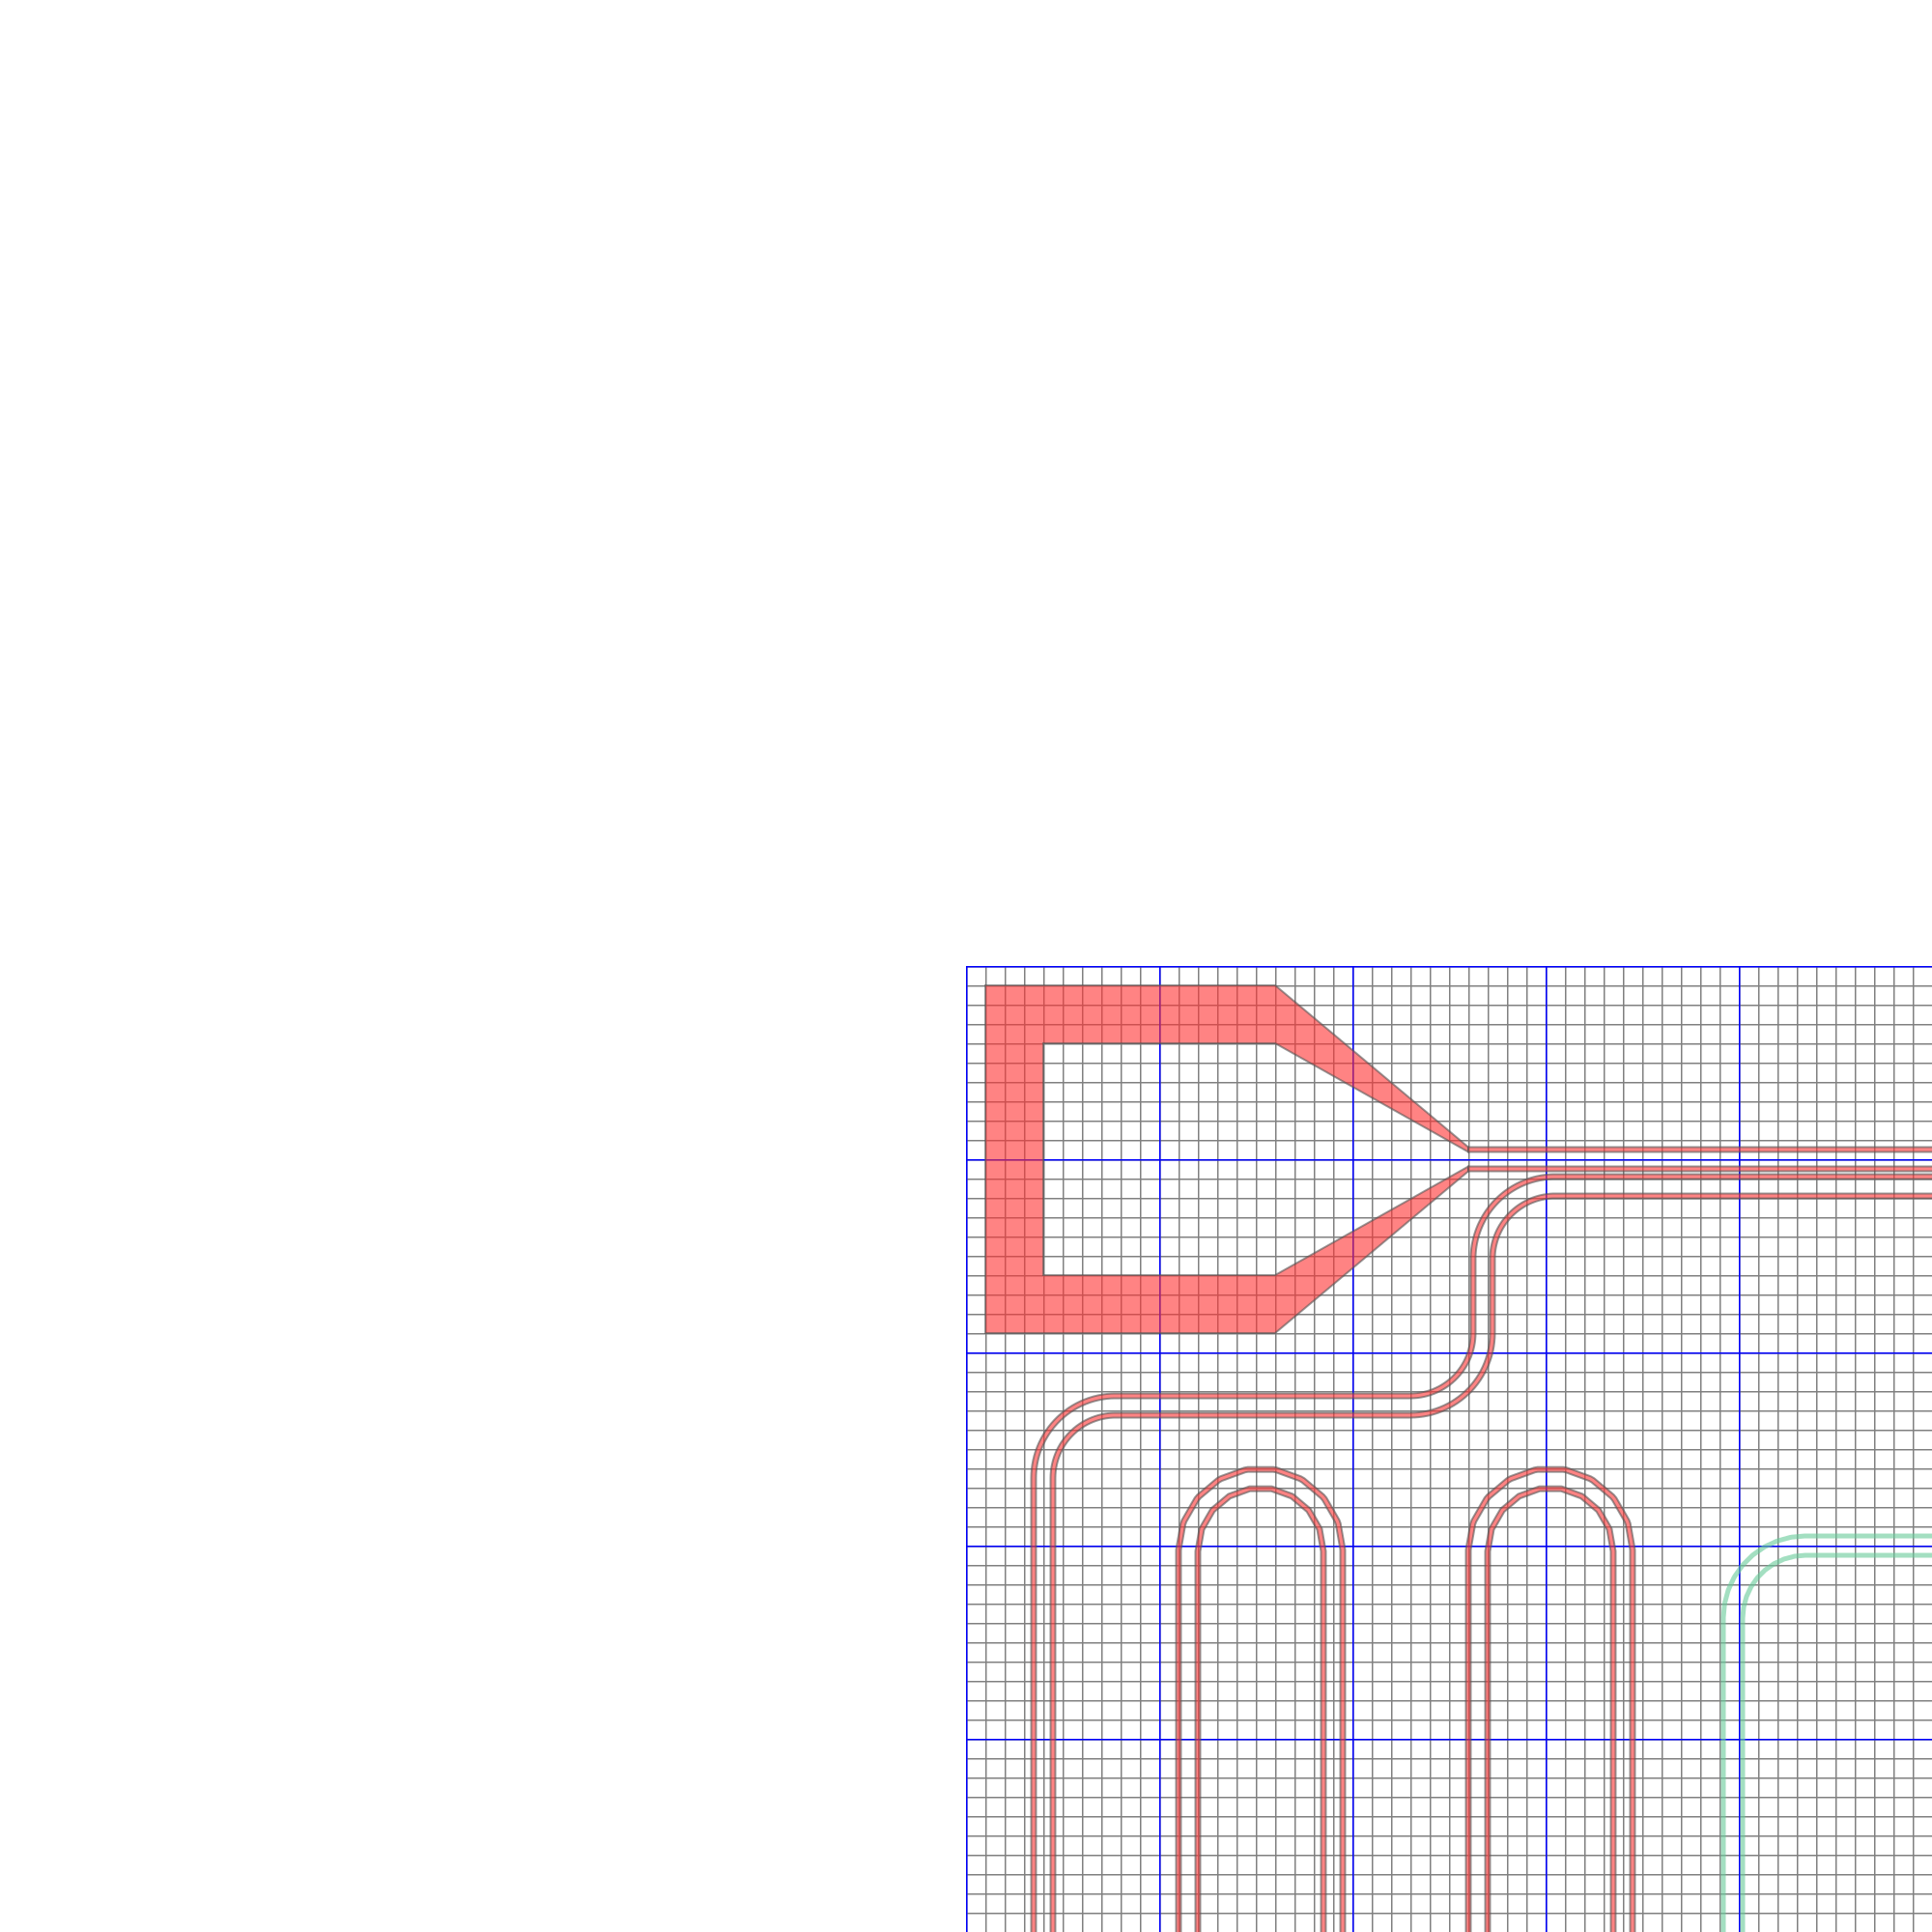

In [10]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( resonator_with_inlauncher ),
    disp.nice_svg( samplespace ),
    *[disp.nice_svg( l ) for l in gate_launchers ],
    disp.nice_svg( flux1L ),
    disp.nice_svg( flux1R ),
    disp.nice_svg( flux2L ),
    disp.nice_svg( flux2R ),
    disp.nice_svg( gate1L ),
    disp.nice_svg( gate1R ),
    disp.nice_svg( gate2L ),
    disp.nice_svg( gate2R ),
    
    
], (0,0,WF,WF)
)

### Patterning
Pattern the ground plane, to prevent noise coming from vortices moving around.

In [11]:
#launchers should no be patterned
launchers = MultiPolygon([
    launchL.convex_hull,
    launchR.convex_hull,
    *[ l.convex_hull for l in gate_launchers ]
])
samplezone = MultiPolygon([
    samplespace,
    inlauncherL,
    inlauncherR
])
lines = MultiLineString([
    feed_line,
    resonator_line,
    flux1_line, flux2_line,
    gate1_line, gate2_line,
])
#pieces that need patterningn around them
patt_zone = sp.ops.unary_union([
    *launchers,
    *samplezone,
    *lines.buffer(s/2+w),
    hanger_endcap
]).buffer(pattern_close)
#part of the design that is not patterned (close to lines and on launchers)
avoid_zone = sp.ops.unary_union([
    *launchers,
    *samplezone,
    *lines.buffer(s/2+w),
    hanger_endcap
]).buffer(pattern_close)

#generate dots
dots = shp.generate_points_tri( pattern_space, (0,0,WF,WF) )
dots = [ d for d in dots if (patt_zone.distance( d ) < pattern_far) and (avoid_zone.distance( d ) > 0)]

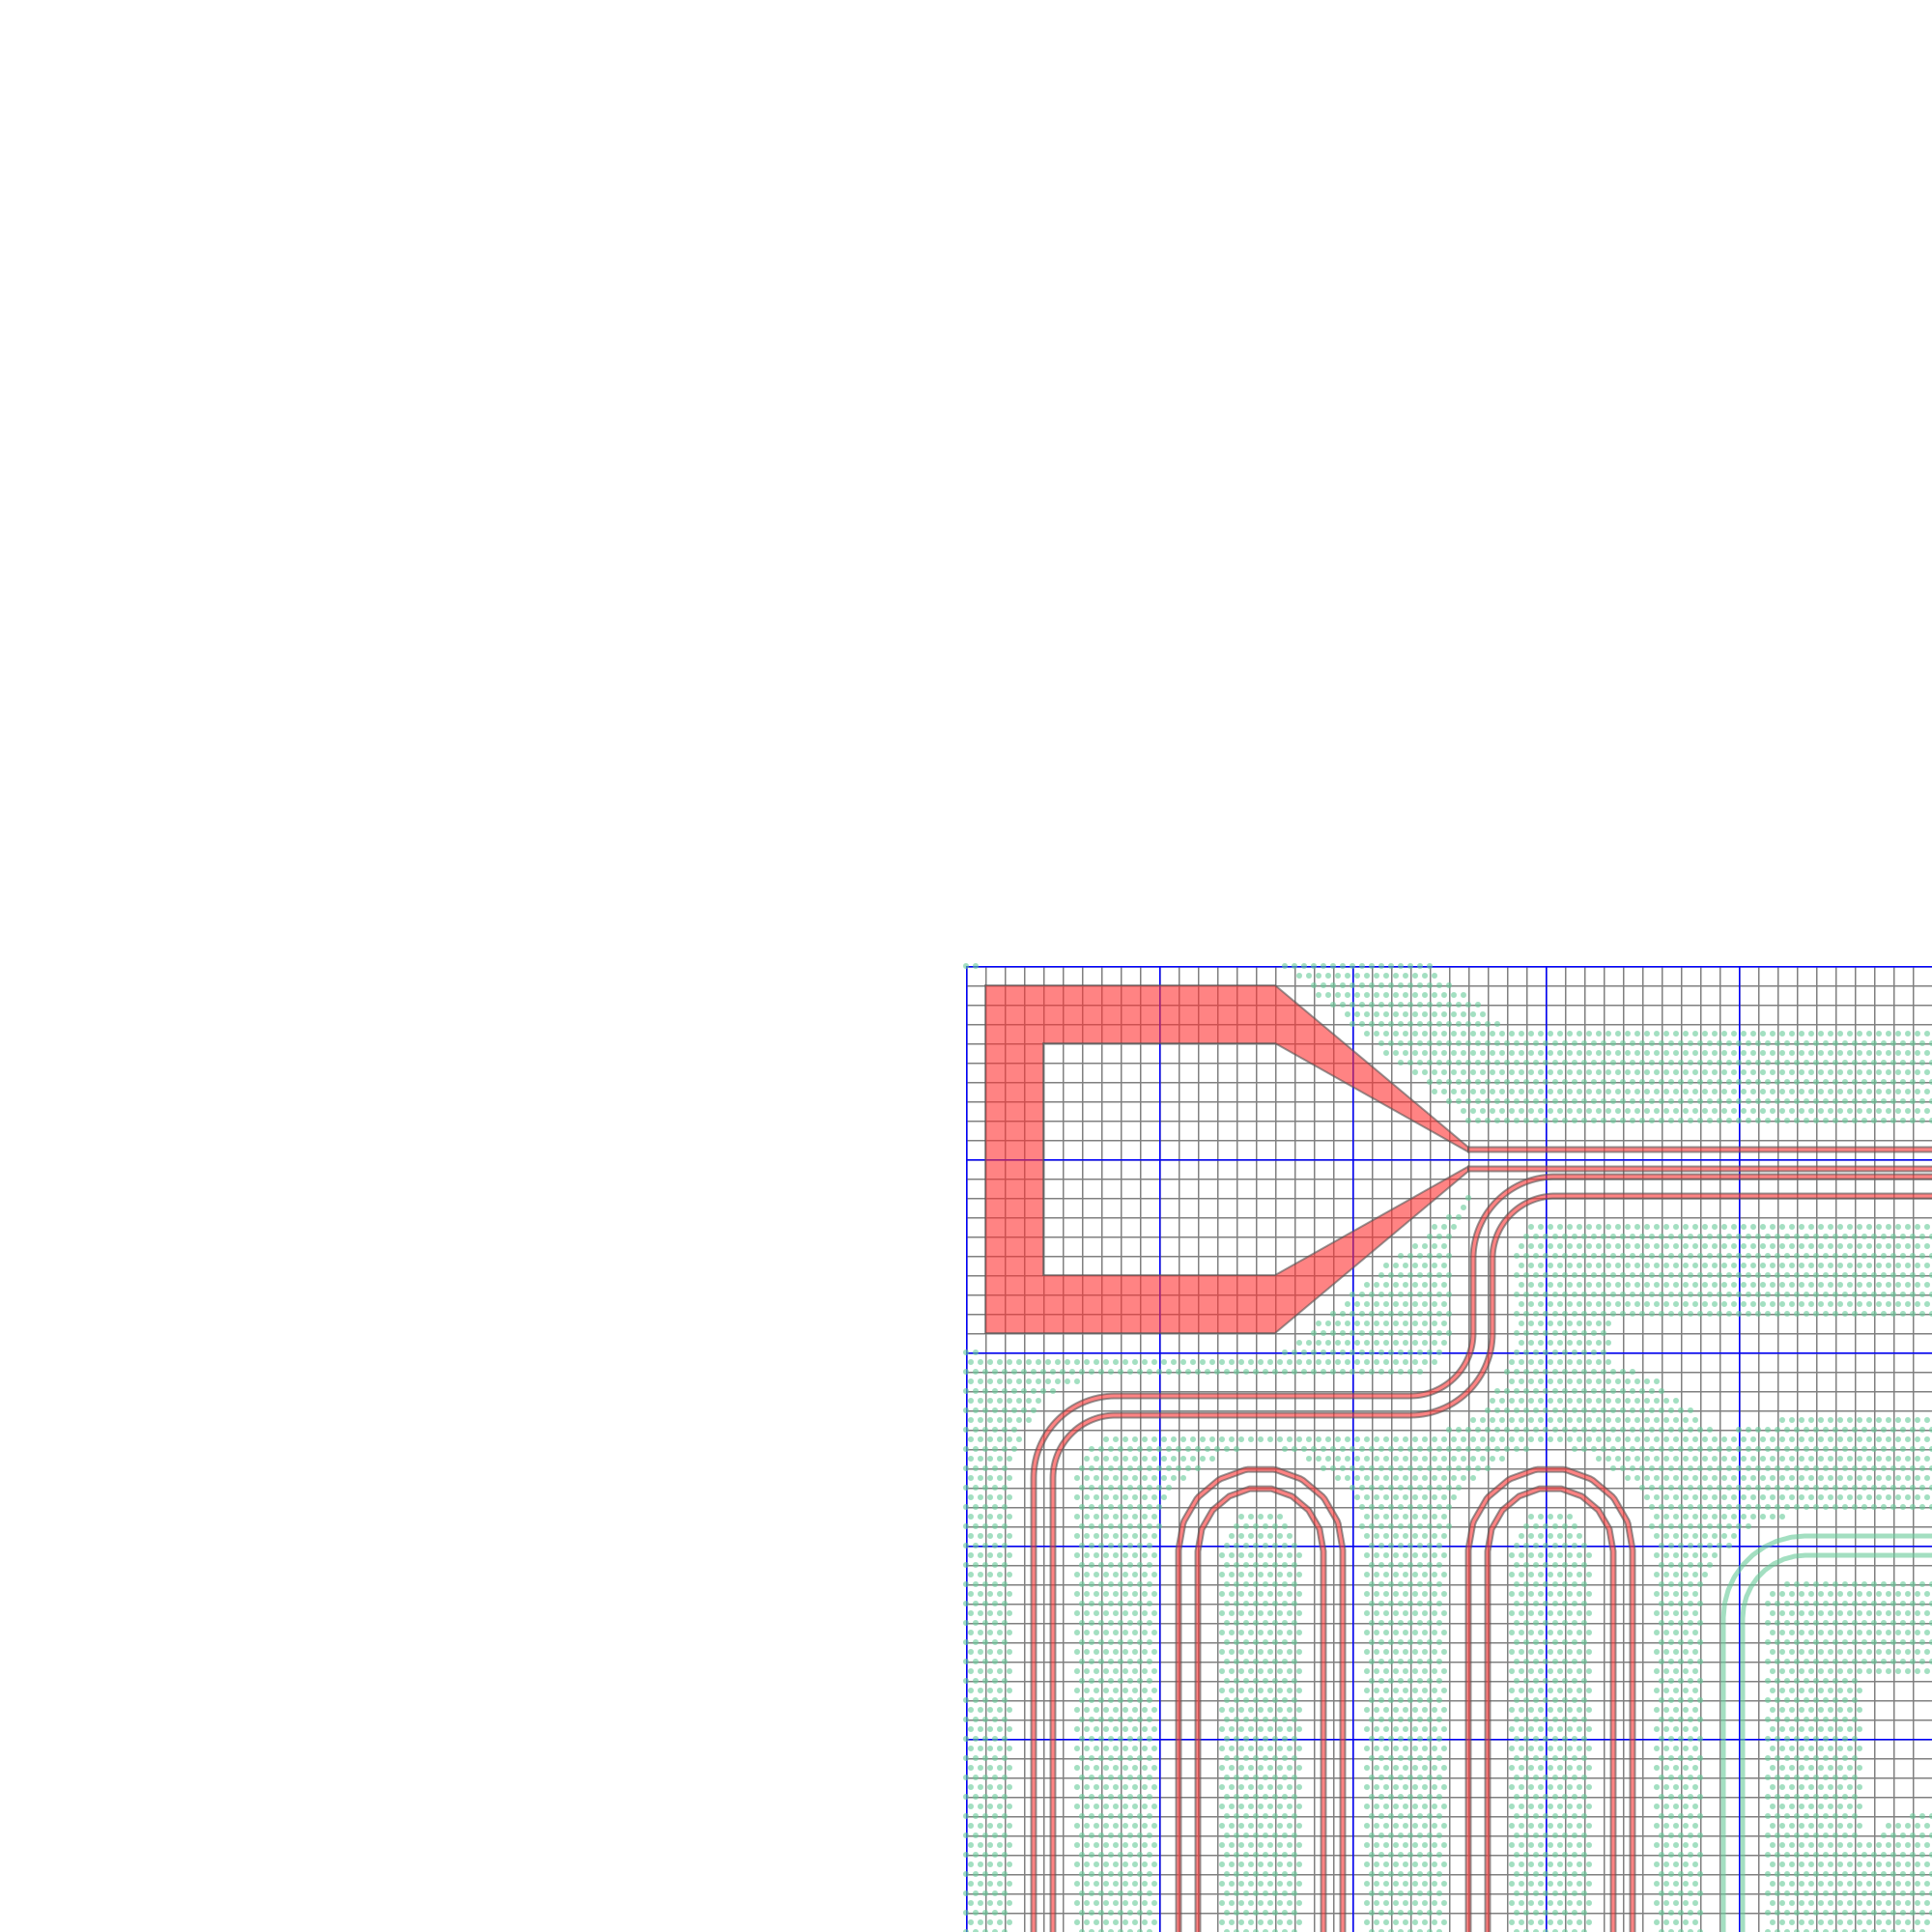

In [12]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    *[disp.nice_svg(d) for d in dots],
    disp.nice_svg( feedline_with_launchers ),
    disp.nice_svg( resonator_with_inlauncher ),
    disp.nice_svg( samplespace ),
    *[disp.nice_svg( l ) for l in gate_launchers ],
    disp.nice_svg( flux1L ),
    disp.nice_svg( flux1R ),
    disp.nice_svg( flux2L ),
    disp.nice_svg( flux2R ),
    disp.nice_svg( gate1L ),
    disp.nice_svg( gate1R ),
    disp.nice_svg( gate2L ),
    disp.nice_svg( gate2R ),
    
], (0,0,WF,WF)
)

### Exporting
Save as, dxf as well as .gds file, also save a read only version of the notebook generating the .dxf and .gds files.

In [15]:
gdss = []
for d in dots:
    gdss.append( gds.poly_to_gds( Polygon( shp.circle_segment( d, .3, 0, np.pi*2 ) ), layer=0) )
for p in feedline_with_launchers:
    gdss.append( gds.poly_to_gds(p, layer=1) )
for p in resonator_with_inlauncher:
    gdss.append( gds.poly_to_gds(p, layer=2) )
gdss.append( gds.poly_to_gds(samplespace, layer=3) )
for p in [gate_launchers[0], flux1L, flux1R]:
    gdss.append( gds.poly_to_gds(p, layer=4) )
for p in [gate_launchers[2], flux2L, flux2R]:
    gdss.append( gds.poly_to_gds(p, layer=5) )
for p in [gate_launchers[1], gate1L, gate1R]:
    gdss.append( gds.poly_to_gds(p, layer=6) )
for p in [gate_launchers[3], gate2L, gate2R]:
    gdss.append( gds.poly_to_gds(p, layer=7) )

gds.save_gds_polys( gdss, "SaclayStyle-2f2gv1.3", save_notebook = True)

In [22]:
dxf.save_dxf([
    *dots,
    *feedline_with_launchers,
    *resonator_with_inlauncher,
    samplespace,
    *gate_launchers,
    flux1L,
    flux1R,
    flux2L,
    flux2R,
    gate1L,
    gate1R,
    gate2L,
    gate2R,
], "SaclayStyle-2f2gv1.3")

In [21]:
import importlib
importlib.reload( dxf )

<module 'export.dxf' from '../export/dxf.py'>